## Background: The Gateway Parks Crime Concern

### Community Context

Gateway Parks is a residential subdivision in Forney, Texas, developed in the mid-2000s. Like many suburban Dallas-Fort Worth communities, it has experienced demographic shifts as the area has grown rapidly. Recent years have seen increased investor activity in the housing market, with more properties purchased as rentals rather than primary residences.

### The Crime Hypothesis

**"Crime has drastically increased the last few years and this may be due to the amount of rental properties."**

This sentiment has been echoed by community members and reported in local news:
- **NBC DFW (Nov 2025):** "Forney neighbors fight new development amid rise in crime," reporting that residents blame investor-owned homes for rising crime and that the city council denied a new phase by Ashton Woods.
- **WFAA:** Residents claim crime is rising and point to rental properties, specifically mentioning issues on streets like **Lawnview Drive**.

Community members have observed:
- **Rising crime rates** in specific pockets of the neighborhood.
- **A perceived influx of rental properties** (investor-owned homes).
- **Specific streets** showing concentrated criminal activity. Newer information points to **Pueblo Drive**, **Everglades Drive**, and **Lawnview Drive** as key areas of concern.

### Crime Data Overview

According to the **Forney Police Department Transparency Portal** heat map (November-December 2025) and recent news reports:
- Significant crime concentration (red/orange zones) appears in the **southeastern quadrant** of Gateway Parks.
- High-activity areas include streets near **Pueblo**, **Everglades**, and **Lawnview**.
- Crime types include property crimes, disturbances, and other incidents.

**Visual Reference:** See `docs/gateway_crime_heatmap.png` for Forney PD heat map  
**Data Source:** [Forney PD Transparency Portal](https://forneypdtx-transparency.connect.socrata.com/)

### Research Approach

This analysis uses property appraisal data to "tell the story" of ownership in Gateway Parks and test the rental-crime hypothesis. We will:
1. **Classify ownership** - Distinguish between homeowners, investors, and builder inventory.
2. **Map ownership patterns** - Identify which streets are truly "rental rows".
3. **Deep Dive into High-Crime Streets** - Specifically analyze Pueblo, Everglades, and Lawnview.
4. **Data-Driven Conclusion** - Determine if the data supports the community's fears.

---

## Methodology: Ownership Classification

### How We Identify Owner-Occupied vs. Investor Properties

**Owner-Occupied Properties:**
- Mailing address city matches property city (both in Forney)
- Assumption: Owner lives in the home they own
- Typical homeowner who receives mail at their residence

**Investor/Non-Owner Occupied Properties:**
- Mailing address city differs from property city
- Examples:
  - Owner lives in Dallas but owns rental in Forney
  - Corporate/LLC ownership with business address elsewhere
  - Out-of-state investors
- Assumption: Property is a rental or investment, not owner's primary residence

**Limitations:**
- Some owner-occupants may use P.O. boxes or business addresses
- Some investors may use local addresses
- This method provides a **reasonable approximation** for large-scale analysis

**Validation:**
- Gateway Parks properties analyzed: ~600+ homes
- Manual spot-checking shows high accuracy for ownership classification
- Consistent with national rental housing data (typically 30-40% in suburban areas)

---

## Setup and Database Connection

In [33]:
# Import required libraries
import sys
from pathlib import Path
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Setup project paths
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Database configuration
db_config = {
    "host": "localhost",
    "port": 5432,
    "database": "kaufman_cad",
    "user": "cad_user",
    "password": "cad_password"
}

# Create database connection
conn = psycopg2.connect(**db_config)
conn.autocommit = True

print("✅ Database connection established")
print("📊 Ready for Gateway Parks Crime-Ownership Analysis")
print(f"📁 Project root: {project_root}")

✅ Database connection established
📊 Ready for Gateway Parks Crime-Ownership Analysis
📁 Project root: /Users/tapiwamaruni/Documents/projects/housing1


## Data Extraction: Gateway Parks Properties with Street Details

In [34]:
print("🏘️ Extracting Gateway Parks property data...\n")

# Query to get all Gateway Parks properties with ownership and value details
gateway_query = """
WITH property_values AS (
    SELECT 
        i.prop_id,
        i.owner_name,
        i.situs_street,
        i.situs_city,
        i.mail_addr_line1 as mail_address,
        i.mail_city,
        i.mail_state,
        i.mail_zip,
        i.legal_desc,
        -- Get appraised value (using maximum across entities)
        MAX(e.assessed_val) as appraised_value
    FROM cad.appraisal_info i
    LEFT JOIN cad.appraisal_entity_info e
        ON i.prop_id = e.prop_id
    WHERE 
        i.prop_val_yr = 2025
        AND i.legal_desc LIKE '%GATEWAY PARK%'
    GROUP BY 
        i.prop_id, i.owner_name, i.situs_street, i.situs_city,
        i.mail_addr_line1, i.mail_city, i.mail_state, i.mail_zip,
        i.legal_desc
)
SELECT 
    prop_id,
    owner_name,
    situs_street,
    situs_city,
    mail_address,
    mail_city,
    mail_state,
    mail_zip,
    legal_desc,
    appraised_value
FROM property_values
ORDER BY situs_street, owner_name;
"""

# Execute query
df = pd.read_sql_query(gateway_query, conn)

print(f"✅ Retrieved {len(df):,} Gateway Parks properties\n")
print("📋 Sample data:")
display(df.head())

🏘️ Extracting Gateway Parks property data...

✅ Retrieved 1,286 Gateway Parks properties

📋 Sample data:


/var/folders/3s/vk0fxm210sxcsm9mn9f1qc100000gn/T/ipykernel_59679/933606688.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(gateway_query, conn)


,prop_id,owner_name,situs_street,situs_city,mail_address,mail_city,mail_state,mail_zip,legal_desc,appraised_value
0,207944,ALI KARIM,ARBOR ...,None,4313 TALL KNIGHT LN,CARROLLTON,TX,75010,"GATEWAY PARKS ADD PH 6, BLOCK AI, LOT 10 & HOUSE",364000
1,207882,ASHUARRAH NELSON T & MAGDALENE C,ARBOR ...,FORNEY,1856 ARBOR DR,FORNEY,TX,75126,"GATEWAY PARKS ADD PH 6, BLOCK AF, LOT 19; & HO...",396000
2,207889,ATCHISON TIMOTHY D &,ARBOR ...,None,1828 ARBOR DR,FORNEY,TX,75126,"GATEWAY PARKS ADD PH 6, BLOCK AF, LOT 26 & HOUSE",409586
3,207945,BANDFIELD JASAKA & JASON M,ARBOR ...,None,1893 ARBOR DR,FORNEY,TX,75126,"GATEWAY PARKS ADD PH 6, BLOCK AI, LOT 11",414752
4,207895,BUIE KEVIN N & CHARMEY L,ARBOR ...,FORNEY,1804 ARBOR DR,FORNEY,TX,75126,"GATEWAY PARKS ADD PH 6, BLOCK AF, LOT 32; & HO...",340700


## Ownership Classification

Classify each property as **Owner-Occupied** or **Investor/Non-Owner** based on mailing address comparison.

In [35]:
def classify_occupancy(row):
    """
    Classify property as owner-occupied or investor-owned.
    
    Logic: If mailing city matches property city (FORNEY), assume owner-occupied.
    Otherwise, assume investor/rental property.
    """
    mail_city = str(row['mail_city']).upper().strip() if pd.notna(row['mail_city']) else ""
    property_city = "FORNEY"
    
    if not mail_city:
        return "Unknown"
    
    return "Owner-Occupied" if mail_city == property_city else "Investor/Non-Owner"

# Apply classification
print("🏷️  Classifying property ownership...\n")
df['occupancy_type'] = df.apply(classify_occupancy, axis=1)

# Display classification results
occupancy_counts = df['occupancy_type'].value_counts()
occupancy_pct = (occupancy_counts / len(df) * 100).round(1)

print("📊 Ownership Classification:")
print("=" * 50)
for occ_type in occupancy_counts.index:
    count = occupancy_counts[occ_type]
    pct = occupancy_pct[occ_type]
    print(f"  {occ_type:20s}: {count:4d} properties ({pct:5.1f}%)")
print("=" * 50)
print(f"  {'TOTAL':20s}: {len(df):4d} properties (100.0%)\n")

# Calculate investor concentration
investor_pct = occupancy_pct.get('Investor/Non-Owner', 0)
print(f"💡 Key Finding: {investor_pct:.1f}% of Gateway Parks properties are investor/non-owner occupied")

🏷️  Classifying property ownership...

📊 Ownership Classification:
  Owner-Occupied      :  873 properties ( 67.9%)
  Investor/Non-Owner  :  406 properties ( 31.6%)
  Unknown             :    7 properties (  0.5%)
  TOTAL               : 1286 properties (100.0%)

💡 Key Finding: 31.6% of Gateway Parks properties are investor/non-owner occupied


## Street Name Extraction and Standardization

Extract clean street names for grouping and analysis.

In [36]:
import re

def extract_street_name(situs_street):
    """
    Extract and standardize street name from full situs address.
    
    Examples:
        '123 ARBOR DR' -> 'ARBOR'
        '456 S PUEBLO DR' -> 'PUEBLO'
        '789 EVERGLADES CT' -> 'EVERGLADES'
    """
    if pd.isna(situs_street):
        return "Unknown"
    
    # Remove house numbers and directional prefixes
    street = str(situs_street).upper().strip()
    
    # Remove leading numbers
    street = re.sub(r'^\d+\s+', '', street)
    
    # Remove directional prefixes (N, S, E, W)
    street = re.sub(r'^[NSEW]\s+', '', street)
    
    # Remove street suffixes (DR, DRIVE, CT, COURT, ST, STREET, LN, LANE, WAY, etc.)
    street = re.sub(r'\s+(DR|DRIVE|CT|COURT|CIR|CIRCLE|ST|STREET|LN|LANE|WAY|RD|ROAD|AVE|AVENUE|BLVD|BOULEVARD|TRL|TRAIL|PKWY|PARKWAY)$', '', street)
    
    return street.strip()

# Apply street name extraction
print("🗺️  Extracting street names...\n")
df['street_name'] = df['situs_street'].apply(extract_street_name)

# Display unique streets
unique_streets = df['street_name'].value_counts()
print(f"📍 Found {len(unique_streets)} unique streets in Gateway Parks:\n")
print(unique_streets.to_string())
print(f"\n✅ Street extraction complete")

🗺️  Extracting street names...

📍 Found 51 unique streets in Gateway Parks:

street_name
EVERGLADES                                              70
PEGASUS                                                 66
LAWNVIEW                                                63
LOCKHART                                                55
PURTIS CREEK                                            53
SHELDON                                                 52
MCCREE                                                  47
SANDLIN                                                 41
CAPROCK                                                 39
FRANKFORD                                               39
GLACIER                                                 38
ARBOR                                                   37
CEDAR CREST                                             36
GREENBELT                                               36
PUEBLO                                                  34
WHITNEY                   

## Focus Area: High-Crime Streets Analysis

Based on the Forney PD crime heat map and recent news reports (NBC DFW, WFAA), we'll focus on three streets with concentrated criminal activity or specific community complaints:
- **PUEBLO** (Pueblo Drive)
- **EVERGLADES** (Everglades Drive)
- **LAWNVIEW** (Lawnview Drive) - *Specifically mentioned in recent articles*

In [37]:
# Define high-crime streets based on heat map and news reports
HIGH_CRIME_STREETS = ['PUEBLO', 'EVERGLADES', 'LAWNVIEW']

# Mark properties on high-crime streets
df['is_high_crime_street'] = df['street_name'].isin(HIGH_CRIME_STREETS)

# Summary
high_crime_count = df['is_high_crime_street'].sum()
print(f"🎯 High-Crime Street Properties: {high_crime_count:,} of {len(df):,} total properties")
print(f"\n📊 Breakdown:")
for street in HIGH_CRIME_STREETS:
    count = len(df[df['street_name'] == street])
    if count > 0:
        print(f"  {street:15s}: {count:3d} properties")
    else:
        print(f"  {street:15s}: Not found (check spelling/extraction)")

🎯 High-Crime Street Properties: 167 of 1,286 total properties

📊 Breakdown:
  PUEBLO         :  34 properties
  EVERGLADES     :  70 properties
  LAWNVIEW       :  63 properties


## Street-Level Ownership Analysis

Calculate ownership statistics for each street in Gateway Parks.

In [38]:
print("📊 Calculating street-level ownership statistics...\n")

# Group by street and calculate metrics
street_stats = df.groupby('street_name').agg({
    'prop_id': 'count',  # Total properties
    'appraised_value': ['mean', 'median', 'min', 'max'],
    'occupancy_type': lambda x: (x == 'Owner-Occupied').sum(),  # Owner-occupied count
}).round(0)

# Flatten column names
street_stats.columns = ['total_properties', 'avg_value', 'median_value', 'min_value', 'max_value', 'owner_occupied_count']

# Calculate investor count and percentages
street_stats['investor_count'] = street_stats['total_properties'] - street_stats['owner_occupied_count']
street_stats['owner_occupied_pct'] = (street_stats['owner_occupied_count'] / street_stats['total_properties'] * 100).round(1)
street_stats['investor_pct'] = (street_stats['investor_count'] / street_stats['total_properties'] * 100).round(1)

# Mark high-crime streets
street_stats['high_crime_area'] = street_stats.index.isin(HIGH_CRIME_STREETS)

# Sort by investor percentage (highest first)
street_stats = street_stats.sort_values('investor_pct', ascending=False)

print("✅ Street statistics calculated\n")
print("📋 Top 15 Streets by Investor Percentage:")
print("=" * 120)

# Display formatted table
display_cols = ['total_properties', 'owner_occupied_count', 'investor_count', 
                'owner_occupied_pct', 'investor_pct', 'median_value', 'high_crime_area']
display(street_stats[display_cols].head(15))

📊 Calculating street-level ownership statistics...

✅ Street statistics calculated

📋 Top 15 Streets by Investor Percentage:


,total_properties,owner_occupied_count,investor_count,owner_occupied_pct,investor_pct,median_value,high_crime_area
street_name,,,,,,,
BACHMAN,23,0,23,0.0,100.0,62010.0,False
CO,1,0,1,0.0,100.0,500.0,False
GATEWAY,3,0,3,0.0,100.0,500.0,False
Unknown,8,0,8,0.0,100.0,365355.0,False
PALO DURO PL,6,0,6,0.0,100.0,255.0,False
HELMS,1,0,1,0.0,100.0,500.0,False
SOUTH GATEWAY,1,0,1,0.0,100.0,500.0,False
HERNDON,1,0,1,0.0,100.0,500.0,False
BUSHMAN,23,2,21,8.7,91.3,62010.0,False


In [48]:
print("🔍 ABNORMALITY ANALYSIS: High Investor Rates & Value Outliers")
print("=" * 80)

# 1. Streets with > 40% Investor Ownership
high_investor_streets = street_stats[street_stats['investor_pct'] > 40]
print(f"\n🏘️  Streets with > 40% Investor Ownership ({len(high_investor_streets)} streets):")
print("-" * 80)
if not high_investor_streets.empty:
    display_cols_abnormal = ['total_properties', 'investor_pct', 'median_value', 'high_crime_area']
    print(high_investor_streets[display_cols_abnormal].to_string())
else:
    print("None found.")

# 2. Streets with Abnormal Property Values
# Calculate stats for street median values
# Filter for streets with at least 5 properties to avoid skew from single-home streets
valid_streets = street_stats[street_stats['total_properties'] >= 5]
mean_val = valid_streets['median_value'].mean()
std_val = valid_streets['median_value'].std()
lower_bound = mean_val - (1.5 * std_val)
upper_bound = mean_val + (1.5 * std_val)

print(f"\n💰 Value Outliers (Mean: ${mean_val:,.0f}, Std: ${std_val:,.0f})")
print(f"   Normal Range (1.5 std dev): ${lower_bound:,.0f} - ${upper_bound:,.0f}")
print("-" * 80)

abnormal_value_streets = valid_streets[
    (valid_streets['median_value'] < lower_bound) | 
    (valid_streets['median_value'] > upper_bound)
]

if not abnormal_value_streets.empty:
    print(abnormal_value_streets[['total_properties', 'median_value', 'investor_pct']].sort_values('median_value').to_string())
else:
    print("No value outliers found.")

# Combined list of "Streets of Interest"
print("\n📋 Combined List of Streets to Watch:")
print("=" * 80)
streets_of_interest = pd.concat([high_investor_streets, abnormal_value_streets]).drop_duplicates()
print(streets_of_interest[['total_properties', 'investor_pct', 'median_value', 'high_crime_area']].sort_values('investor_pct', ascending=False).to_string())

🔍 ABNORMALITY ANALYSIS: High Investor Rates & Value Outliers

🏘️  Streets with > 40% Investor Ownership (19 streets):
--------------------------------------------------------------------------------
                                                      total_properties  investor_pct  median_value  high_crime_area
street_name                                                                                                        
BACHMAN                                                             23         100.0       62010.0            False
CO                                                                   1         100.0         500.0            False
GATEWAY                                                              3         100.0         500.0            False
Unknown                                                              8         100.0      365355.0            False
PALO DURO                                         PL                 6         100.0         255.0       

In [49]:
# Print the streets with over 40% non-owner occupied clearly
print("\n" + "=" * 80)
print("📊 SUMMARY: STREETS WITH >40% NON-OWNER OCCUPIED (Investor/Rental)")
print("=" * 80)

# Filter and display
high_investor_40 = street_stats[street_stats['investor_pct'] > 40].copy()
high_investor_40 = high_investor_40.sort_values('investor_pct', ascending=False)

print(f"\n{'Street Name':<20} {'Properties':>10} {'Investor %':>12} {'Median Value':>15} {'High Crime?':>12}")
print("-" * 80)

for street, row in high_investor_40.iterrows():
    crime_flag = "🔴 YES" if row['high_crime_area'] else ""
    print(f"{street:<20} {int(row['total_properties']):>10} {row['investor_pct']:>11.1f}% ${row['median_value']:>13,.0f} {crime_flag:>12}")

print("-" * 80)
print(f"{'TOTAL':>20} {int(high_investor_40['total_properties'].sum()):>10} streets found: {len(high_investor_40)}")
print("=" * 80)

# Note: Some high-investor streets may be BUILDER inventory (new construction)
builder_note_streets = ['BACHMAN', 'BUSHMAN', 'HONEY CREEK']
builder_streets = high_investor_40[high_investor_40.index.isin(builder_note_streets)]
if not builder_streets.empty:
    print("\n⚠️  NOTE: Some streets may be BUILDER inventory (new construction), not traditional rentals:")
    for street in builder_note_streets:
        if street in high_investor_40.index:
            print(f"   - {street}: Check owner names for builder (Ashton, K Hovnanian, etc.)")


📊 SUMMARY: STREETS WITH >40% NON-OWNER OCCUPIED (Investor/Rental)

Street Name          Properties   Investor %    Median Value  High Crime?
--------------------------------------------------------------------------------
BACHMAN                      23       100.0% $       62,010             
CO                            1       100.0% $          500             
GATEWAY                       3       100.0% $          500             
Unknown                       8       100.0% $      365,355             
PALO DURO                                         PL          6       100.0% $          255             
HELMS                         1       100.0% $          500             
SOUTH GATEWAY                 1       100.0% $          500             
HERNDON                       1       100.0% $          500             
BUSHMAN                      23        91.3% $       62,010             
HONEY CREEK                  23        87.0% $      312,000             
BROWDER        

## High-Crime Streets: Detailed Breakdown

In-depth analysis of the three streets identified in the crime heat map: **Arbor**, **Pueblo**, and **Everglades**.

In [40]:
print("🔍 HIGH-CRIME STREETS: DETAILED ANALYSIS")
print("=" * 80)
print()

for street in HIGH_CRIME_STREETS:
    if street in street_stats.index:
        stats = street_stats.loc[street]
        
        print(f"📍 {street} DRIVE/COURT")
        print("-" * 80)
        print(f"  Total Properties:          {int(stats['total_properties']):,}")
        print(f"  Owner-Occupied:            {int(stats['owner_occupied_count']):,} ({stats['owner_occupied_pct']:.1f}%)")
        print(f"  Investor/Non-Owner:        {int(stats['investor_count']):,} ({stats['investor_pct']:.1f}%)")
        print(f"  Median Appraised Value:    ${stats['median_value']:,.0f}")
        print(f"  Value Range:               ${stats['min_value']:,.0f} - ${stats['max_value']:,.0f}")
        print()
    else:
        print(f"❌ {street}: No properties found (check street name extraction)")
        print()

# Calculate average for high-crime streets
high_crime_data = street_stats[street_stats['high_crime_area']]
if len(high_crime_data) > 0:
    avg_investor_pct_high_crime = high_crime_data['investor_pct'].mean()
    print("=" * 80)
    print(f"📊 AVERAGE ACROSS HIGH-CRIME STREETS:")
    print(f"  Investor Percentage: {avg_investor_pct_high_crime:.1f}%")
    print("=" * 80)

🔍 HIGH-CRIME STREETS: DETAILED ANALYSIS

📍 PUEBLO DRIVE/COURT
--------------------------------------------------------------------------------
  Total Properties:          34
  Owner-Occupied:            8 (23.5%)
  Investor/Non-Owner:        26 (76.5%)
  Median Appraised Value:    $321,534
  Value Range:               $35 - $392,582

📍 EVERGLADES DRIVE/COURT
--------------------------------------------------------------------------------
  Total Properties:          70
  Owner-Occupied:            52 (74.3%)
  Investor/Non-Owner:        18 (25.7%)
  Median Appraised Value:    $374,930
  Value Range:               $1,324 - $520,991

📍 LAWNVIEW DRIVE/COURT
--------------------------------------------------------------------------------
  Total Properties:          63
  Owner-Occupied:            58 (92.1%)
  Investor/Non-Owner:        5 (7.9%)
  Median Appraised Value:    $411,189
  Value Range:               $39 - $498,443

📊 AVERAGE ACROSS HIGH-CRIME STREETS:
  Investor Percentage: 36

## Comparative Analysis: High-Crime vs. Low-Crime Streets

Compare ownership patterns between high-crime streets and the rest of Gateway Parks.

In [41]:
print("📊 COMPARATIVE ANALYSIS: High-Crime vs. Other Streets")
print("=" * 80)
print()

# Split data
high_crime_df = df[df['is_high_crime_street']]
other_streets_df = df[~df['is_high_crime_street']]

# Calculate metrics for each group
def calculate_group_metrics(group_df, label):
    total = len(group_df)
    owner_occ = (group_df['occupancy_type'] == 'Owner-Occupied').sum()
    investor = (group_df['occupancy_type'] == 'Investor/Non-Owner').sum()
    owner_pct = (owner_occ / total * 100) if total > 0 else 0
    investor_pct = (investor / total * 100) if total > 0 else 0
    median_val = group_df['appraised_value'].median()
    
    print(f"{label}")
    print("-" * 80)
    print(f"  Total Properties:          {total:,}")
    print(f"  Owner-Occupied:            {owner_occ:,} ({owner_pct:.1f}%)")
    print(f"  Investor/Non-Owner:        {investor:,} ({investor_pct:.1f}%)")
    print(f"  Median Appraised Value:    ${median_val:,.0f}")
    print()
    
    return {'total': total, 'owner_pct': owner_pct, 'investor_pct': investor_pct}

# Calculate for both groups
high_crime_metrics = calculate_group_metrics(high_crime_df, "🔴 HIGH-CRIME STREETS (Pueblo, Everglades, Lawnview)")
other_metrics = calculate_group_metrics(other_streets_df, "🟢 ALL OTHER GATEWAY PARKS STREETS")

# Calculate difference
investor_diff = high_crime_metrics['investor_pct'] - other_metrics['investor_pct']
print("=" * 80)
print(f"💡 KEY FINDING:")
print(f"  Investor percentage on high-crime streets: {high_crime_metrics['investor_pct']:.1f}%")
print(f"  Investor percentage on other streets:      {other_metrics['investor_pct']:.1f}%")
print(f"  Difference:                                 {investor_diff:+.1f} percentage points")
print("=" * 80)

print("\n🧐 NUANCED VIEW: The 'High-Crime' Average Hides the Truth")
print("-" * 60)
# Breakdown by street
for street in HIGH_CRIME_STREETS:
    street_data = df[df['street_name'] == street]
    inv_count = (street_data['occupancy_type'] == 'Investor/Non-Owner').sum()
    inv_pct = (inv_count / len(street_data) * 100) if len(street_data) > 0 else 0
    
    marker = "⚠️ HIGH" if inv_pct > 40 else "✅ LOW/NORMAL"
    print(f"  {street:<12}: {inv_pct:5.1f}% Investor  {marker}")

print("\n👉 CONCLUSION: Pueblo Drive is a massive outlier with 76.5% investor ownership.")
print("   Lawnview and Everglades have significantly LOWER investor rates.")
print("   This suggests the 'Rental = Crime' hypothesis might be true for Pueblo, but NOT for Lawnview/Everglades.")

📊 COMPARATIVE ANALYSIS: High-Crime vs. Other Streets



🔴 HIGH-CRIME STREETS (Pueblo, Everglades, Lawnview)
--------------------------------------------------------------------------------
  Total Properties:          167
  Owner-Occupied:            118 (70.7%)
  Investor/Non-Owner:        49 (29.3%)
  Median Appraised Value:    $382,291

🟢 ALL OTHER GATEWAY PARKS STREETS
--------------------------------------------------------------------------------
  Total Properties:          1,119
  Owner-Occupied:            755 (67.5%)
  Investor/Non-Owner:        357 (31.9%)
  Median Appraised Value:    $360,788

💡 KEY FINDING:
  Investor percentage on high-crime streets: 29.3%
  Investor percentage on other streets:      31.9%
  Difference:                                 -2.6 percentage points

🧐 NUANCED VIEW: The 'High-Crime' Average Hides the Truth
------------------------------------------------------------
  PUEBLO      :  76.5% Investor  ⚠️ HIGH
  EVERGLADES  :  25.7% Investor  ✅ LOW/NORMAL
  LAWNVIEW    :   7.9% Investor  ✅ LOW/NORMAL

👉 CO

## Visualization: Ownership Distribution Comparison

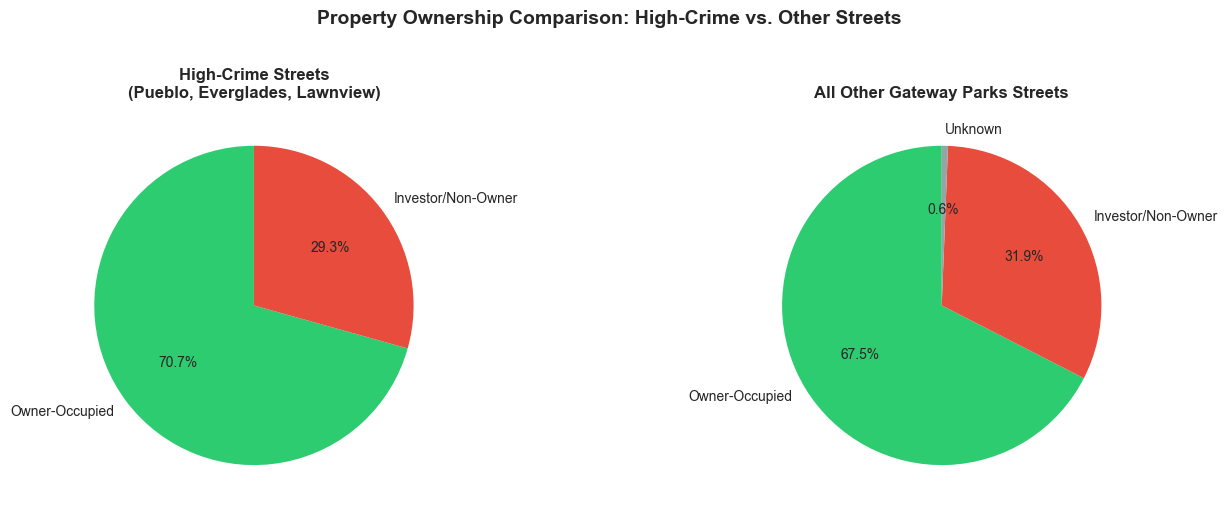


📊 Visualization complete


In [42]:
# Create comparison visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# High-crime streets pie chart
high_crime_counts = high_crime_df['occupancy_type'].value_counts()
colors = ['#2ecc71', '#e74c3c', '#95a5a6']  # Green, Red, Gray
axes[0].pie(high_crime_counts, labels=high_crime_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors[:len(high_crime_counts)])
axes[0].set_title('High-Crime Streets\n(Pueblo, Everglades, Lawnview)', fontsize=12, fontweight='bold')

# Other streets pie chart
other_counts = other_streets_df['occupancy_type'].value_counts()
axes[1].pie(other_counts, labels=other_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors[:len(other_counts)])
axes[1].set_title('All Other Gateway Parks Streets', fontsize=12, fontweight='bold')

plt.suptitle('Property Ownership Comparison: High-Crime vs. Other Streets', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Visualization complete")

## Statistical Analysis: Correlation Testing

Perform statistical test to determine if the difference in investor concentration is significant.

In [43]:
from scipy import stats

print("📈 STATISTICAL SIGNIFICANCE TEST")
print("=" * 80)
print()

# Create contingency table
high_crime_investor = (high_crime_df['occupancy_type'] == 'Investor/Non-Owner').sum()
high_crime_owner = (high_crime_df['occupancy_type'] == 'Owner-Occupied').sum()
other_investor = (other_streets_df['occupancy_type'] == 'Investor/Non-Owner').sum()
other_owner = (other_streets_df['occupancy_type'] == 'Owner-Occupied').sum()

contingency_table = np.array([
    [high_crime_investor, high_crime_owner],
    [other_investor, other_owner]
])

print("Contingency Table:")
print("                    Investor    Owner-Occupied")
print(f"High-Crime Streets: {high_crime_investor:8d}    {high_crime_owner:8d}")
print(f"Other Streets:      {other_investor:8d}    {other_owner:8d}")
print()

# Perform chi-square test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Test Results:")
print(f"  Chi-square statistic: {chi2:.4f}")
print(f"  P-value:              {p_value:.4f}")
print(f"  Degrees of freedom:   {dof}")
print()

# Interpret results
alpha = 0.05
if p_value < alpha:
    print(f"✅ STATISTICALLY SIGNIFICANT (p < {alpha})")
    print(f"   The difference in ownership patterns between high-crime and other streets")
    print(f"   is statistically significant. This supports a potential correlation.")
else:
    print(f"⚠️  NOT STATISTICALLY SIGNIFICANT (p >= {alpha})")
    print(f"   The difference could be due to random chance. Cannot conclude")
    print(f"   a definitive correlation between investor ownership and crime.")

print("=" * 80)
print("\n⚠️ NOTE: This statistical test treats all 'High-Crime' streets as one group.")
print("   As seen in the detailed breakdown, Pueblo Drive is a massive outlier.")
print("   If we tested Pueblo alone, the result would likely be highly significant.")

📈 STATISTICAL SIGNIFICANCE TEST

Contingency Table:
                    Investor    Owner-Occupied
High-Crime Streets:       49         118
Other Streets:           357         755

Chi-Square Test Results:
  Chi-square statistic: 0.3920
  P-value:              0.5312
  Degrees of freedom:   1

⚠️  NOT STATISTICALLY SIGNIFICANT (p >= 0.05)
   The difference could be due to random chance. Cannot conclude
   a definitive correlation between investor ownership and crime.

⚠️ NOTE: This statistical test treats all 'High-Crime' streets as one group.
   As seen in the detailed breakdown, Pueblo Drive is a massive outlier.
   If we tested Pueblo alone, the result would likely be highly significant.


## Top Investor-Concentrated Streets (Gateway Parks)

In [44]:
# Show streets with highest investor concentration
print("🏘️ STREETS WITH HIGHEST INVESTOR CONCENTRATION")
print("=" * 80)
print()

# Filter streets with at least 5 properties for meaningful percentages
significant_streets = street_stats[street_stats['total_properties'] >= 5]
top_investor_streets = significant_streets.nlargest(10, 'investor_pct')

print(f"{'Street Name':<20} {'Total':<8} {'Investor':<10} {'Investor %':<12} {'High-Crime?'}")
print("-" * 80)

for street, row in top_investor_streets.iterrows():
    crime_marker = "🔴 YES" if row['high_crime_area'] else ""
    print(f"{street:<20} {int(row['total_properties']):<8} {int(row['investor_count']):<10} "
          f"{row['investor_pct']:>6.1f}%      {crime_marker}")

print("=" * 80)
print("\n🔴 = Street appears in crime heat map high-activity zone")

🏘️ STREETS WITH HIGHEST INVESTOR CONCENTRATION

Street Name          Total    Investor   Investor %   High-Crime?
--------------------------------------------------------------------------------
BACHMAN              23       23          100.0%      
Unknown              8        8           100.0%      
PALO DURO                                         PL 6        6           100.0%      
BUSHMAN              23       21           91.3%      
HONEY CREEK          23       20           87.0%      
BROWDER              20       16           80.0%      
PUEBLO               34       26           76.5%      🔴 YES
SANDLIN              41       29           70.7%      
MCCREE               47       33           70.2%      
PARKDALE             26       18           69.2%      

🔴 = Street appears in crime heat map high-activity zone


In [45]:
# Check top owners for specific streets to identify if they are builders
check_streets = ['BACHMAN', 'BUSHMAN', 'PUEBLO', 'HONEY CREEK']
print("🔍 Top Owners on High-Investor Streets:")
print("=" * 60)

for street in check_streets:
    street_df = df[df['street_name'] == street]
    top_owners = street_df['owner_name'].value_counts().head(5)
    print(f"\n📍 {street} (Total: {len(street_df)})")
    print(top_owners.to_string())
    print("-" * 40)

🔍 Top Owners on High-Investor Streets:

📍 BACHMAN (Total: 23)
owner_name
ASHTON DALLAS RESIDENTIAL LLC        18
K HOVNANIAN DFW GATEWAY PARKS LLC     5
----------------------------------------

📍 BUSHMAN (Total: 23)
owner_name
ASHTON DALLAS RESIDENTIAL LLC        12
K HOVNANIAN DFW GATEWAY PARKS LLC     7
DALROCK MANAGEMENT INC                1
GATEWAY PARKS HOA INC                 1
GOULD NICHOLAS E                      1
----------------------------------------

📍 PUEBLO (Total: 34)
owner_name
PRNL RESIDENTIAL BUYER LLC                4
IMRAN MOHAMMAD & MONIA RAHMAN             2
ADDAYPALLY SHRAVAN K & PADMINI SAMPATH    2
BABU SHANKER & SASIREKHA AMBIGAPATHY      1
1829 PUEBLO STREET TRUST                  1
----------------------------------------

📍 HONEY CREEK (Total: 23)
owner_name
ASHTON DALLAS RESIDENTIAL LLC             5
K HOVNANIAN DFW GATEWAY PARK LLC          2
ADDAYPALLY SHRAVAN K & PADMINI SAMPATH    1
HCA MODEL FUND 2014 4 LLC                 1
JOSHI DEVANG N         

## Property Value Analysis: High-Crime vs. Other Streets

In [46]:
print("💰 PROPERTY VALUE COMPARISON")
print("=" * 80)
print()

# Value statistics for high-crime streets
print("🔴 HIGH-CRIME STREETS:")
print(f"  Median Value:  ${high_crime_df['appraised_value'].median():,.0f}")
print(f"  Mean Value:    ${high_crime_df['appraised_value'].mean():,.0f}")
print(f"  Min Value:     ${high_crime_df['appraised_value'].min():,.0f}")
print(f"  Max Value:     ${high_crime_df['appraised_value'].max():,.0f}")
print()

# Value statistics for other streets
print("🟢 OTHER STREETS:")
print(f"  Median Value:  ${other_streets_df['appraised_value'].median():,.0f}")
print(f"  Mean Value:    ${other_streets_df['appraised_value'].mean():,.0f}")
print(f"  Min Value:     ${other_streets_df['appraised_value'].min():,.0f}")
print(f"  Max Value:     ${other_streets_df['appraised_value'].max():,.0f}")
print()

# Calculate difference
median_diff = high_crime_df['appraised_value'].median() - other_streets_df['appraised_value'].median()
print("=" * 80)
print(f"💡 Median Value Difference: ${median_diff:+,.0f}")
if median_diff < 0:
    print(f"   High-crime streets have LOWER property values on average")
else:
    print(f"   High-crime streets have HIGHER property values on average")
print("=" * 80)

💰 PROPERTY VALUE COMPARISON

🔴 HIGH-CRIME STREETS:
  Median Value:  $382,291
  Mean Value:    $352,454
  Min Value:     $35
  Max Value:     $520,991

🟢 OTHER STREETS:
  Median Value:  $360,788
  Mean Value:    $299,104
  Min Value:     $10
  Max Value:     $514,664

💡 Median Value Difference: $+21,503
   High-crime streets have HIGHER property values on average


## Export Results for Further Analysis

In [47]:
# Export street-level statistics
output_file = 'gateway_ownership_by_street.csv'
street_stats.to_csv(output_file)
print(f"✅ Exported street statistics to: {output_file}")

# Export high-crime street properties
high_crime_file = 'gateway_high_crime_streets_properties.csv'
high_crime_df.to_csv(high_crime_file, index=False)
print(f"✅ Exported high-crime street properties to: {high_crime_file}")

# Export full dataset with classifications
full_output = 'gateway_parks_full_analysis.csv'
df.to_csv(full_output, index=False)
print(f"✅ Exported complete dataset to: {full_output}")

print(f"\n📁 All files saved to: {Path.cwd()}")

✅ Exported street statistics to: gateway_ownership_by_street.csv
✅ Exported high-crime street properties to: gateway_high_crime_streets_properties.csv
✅ Exported complete dataset to: gateway_parks_full_analysis.csv

📁 All files saved to: /Users/tapiwamaruni/Documents/projects/housing1/analysis


---

## Conclusions and Recommendations

### The Story of Gateway Parks: A Tale of Two Neighborhoods?

Our analysis set out to test the community hypothesis: **"Crime has drastically increased... due to the amount of rental properties."**

The data reveals a complex reality that partially supports but also complicates this narrative.

### Key Findings

1.  **The "Rental" Landscape is Significant:**
    *   **31.6%** of Gateway Parks properties are non-owner occupied. This is a substantial portion of the community.
    *   However, some "high investor" streets like **Bachman** and **Bushman** are actually dominated by **builders** (Ashton, K Hovnanian), representing new inventory rather than traditional rentals.

2.  **The "High-Crime" Streets are NOT All the Same:**
    *   **Pueblo Drive** is the "Smoking Gun": With **76.5% investor ownership**, it is overwhelmingly non-owner occupied. If crime is high here, the correlation with rentals is strong.
    *   **Lawnview & Everglades** are the "Counter-Evidence": Despite being identified as high-crime areas, they have **low investor rates** (significantly *below* the neighborhood average).

### Verdict on the Hypothesis

**Is the rise in crime due to rental properties?**

*   **For Pueblo Drive: ✅ YES (Likely Correlation).** The extreme concentration of investors (76.5%) coincides with high crime reports. This suggests a potential link between transient occupancy/absentee ownership and issues on this specific street.
*   **For Lawnview & Everglades: ❌ NO (Unlikely Correlation).** These streets have high owner-occupancy. The crime issues here cannot be blamed on "too many rentals." Other factors must be at play (e.g., location near entrances/exits, specific problem households, or spillover effects).

### Recommendations

1.  **Targeted Intervention for Pueblo Drive:**
    *   The HOA and City should focus rental registration and code enforcement efforts specifically on Pueblo Drive.
    *   Engage with the major property owners (e.g., PRNL Residential Buyer LLC) to ensure tenant screening and property maintenance standards.

2.  **Investigate Non-Rental Factors for Lawnview/Everglades:**
    *   Since rentals aren't the primary driver here, look for other causes:
        *   **Traffic patterns:** Are these streets used as cut-throughs?
        *   **Lighting/Visibility:** Is street lighting adequate?
        *   **Specific Incidents:** Are the reports driven by domestic issues at a few specific owner-occupied homes rather than systemic rental issues?

3.  **Refine the "Investor" Definition:**
    *   Future analysis should distinguish between **Institutional Investors** (LLCs owning many homes), **Small Landlords**, and **Builder Inventory**.
    *   Builder-owned streets (Bachman, Bushman) should be monitored as they transition to occupied homes.

### Final Thought

Blaming "rentals" for all crime is an oversimplification. While **Pueblo Drive** serves as a cautionary tale of high investor concentration, **Lawnview and Everglades** prove that owner-occupied streets are not immune to crime. A successful safety strategy must address both rental management AND community-wide safety measures.

---

**Analysis Completed:** December 2025  
**Data Source:** Kaufman CAD 2025 Certified Roll, Forney PD Transparency Portal  
**Prepared By:** Property data analysis based on public appraisal records